## 1. Importação de bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import apriori, association_rules

## 2. Carregamento dos dados

In [13]:
df = pd.read_csv("candidatos_2024\consulta_cand_2024_PR.csv", sep=';', encoding='latin1')
df.shape

<>:1: DeprecationWarning: invalid escape sequence '\c'
<>:1: DeprecationWarning: invalid escape sequence '\c'
C:\Users\Eitão\AppData\Local\Temp\ipykernel_10500\2630535292.py:1: DeprecationWarning: invalid escape sequence '\c'
  df = pd.read_csv("candidatos_2024\consulta_cand_2024_PR.csv", sep=';', encoding='latin1')


(34021, 50)

## 3. Pré-processamento

In [20]:
df = df[['DS_OCUPACAO', 'DS_GRAU_INSTRUCAO', 'DS_COR_RACA', 'DS_GENERO',
         'DT_NASCIMENTO', 'DS_ESTADO_CIVIL', 'SG_PARTIDO', 'NM_PARTIDO', 'DS_SIT_TOT_TURNO']]

# Idade
df['DT_NASCIMENTO'] = pd.to_datetime(df['DT_NASCIMENTO'], errors='coerce')
df['IDADE'] = 2024 - df['DT_NASCIMENTO'].dt.year

# Se foi eleito
df['ELEITO'] = df['DS_SIT_TOT_TURNO'].apply(lambda x: 1 if 'ELEITO' in str(x).upper() else 0)

# Faixa etária
df['FAIXA_ETARIA'] = pd.cut(df['IDADE'], bins=[0, 29, 45, 60, 100], labels=['Jovem', 'Adulto', 'Meia-idade', 'Idoso'])

# Limpar nulos
df = df.dropna(subset=['DS_OCUPACAO', 'DS_GRAU_INSTRUCAO', 'DS_COR_RACA', 'DS_GENERO', 'DS_ESTADO_CIVIL', 'SG_PARTIDO', 'NM_PARTIDO'])

## 4. Análise exploratória

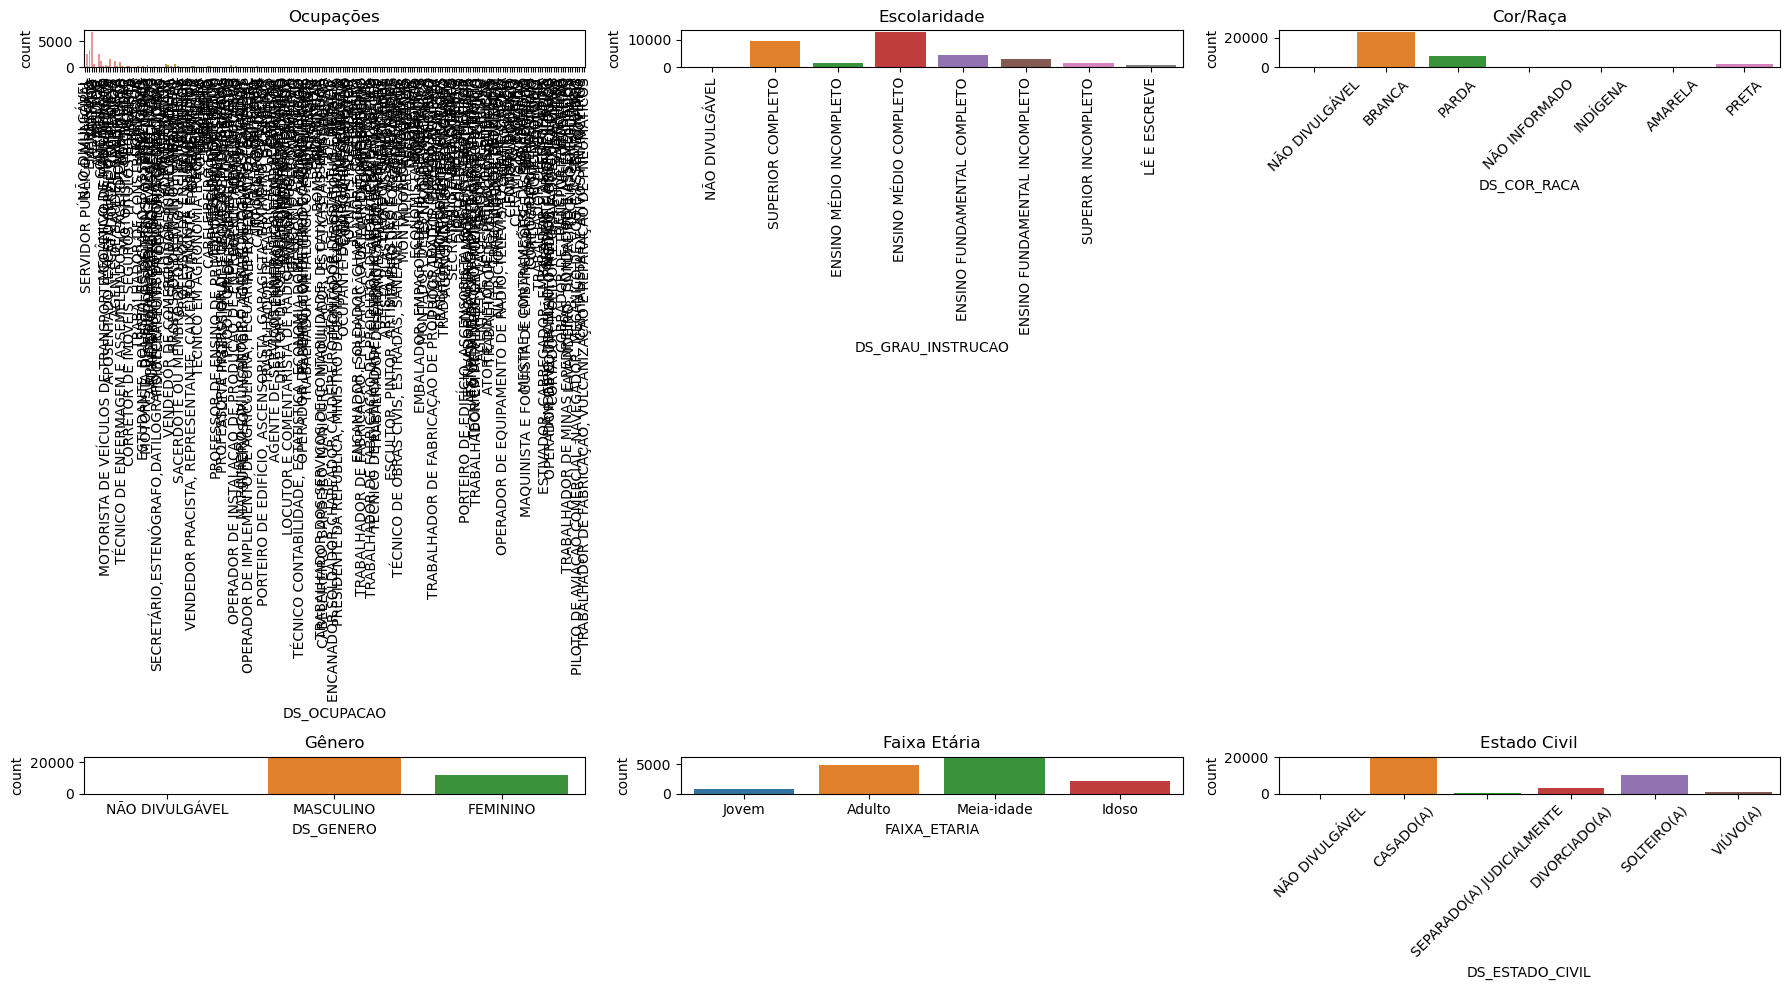

Partidos com mais candidatos:
NM_PARTIDO
PARTIDO SOCIAL DEMOCRÁTICO          3885
PROGRESSISTAS                       3243
PARTIDO LIBERAL                     3153
MOVIMENTO DEMOCRÁTICO BRASILEIRO    3062
UNIÃO BRASIL                        2922
PARTIDO DOS TRABALHADORES           2097
REPUBLICANOS                        2071
PODEMOS                             1876
PARTIDO SOCIALISTA BRASILEIRO       1817
PARTIDO DEMOCRÁTICO TRABALHISTA     1421
Name: count, dtype: int64

Partidos com mais eleitos:
NM_PARTIDO
PARTIDO SOCIAL DEMOCRÁTICO          1363
PARTIDO DOS TRABALHADORES           1290
PARTIDO LIBERAL                     1199
PROGRESSISTAS                       1196
UNIÃO BRASIL                        1160
MOVIMENTO DEMOCRÁTICO BRASILEIRO    1159
PARTIDO DEMOCRÁTICO TRABALHISTA      888
PARTIDO SOCIALISTA BRASILEIRO        855
PODEMOS                              835
PARTIDO RENOVAÇÃO DEMOCRÁTICA        753
Name: count, dtype: int64


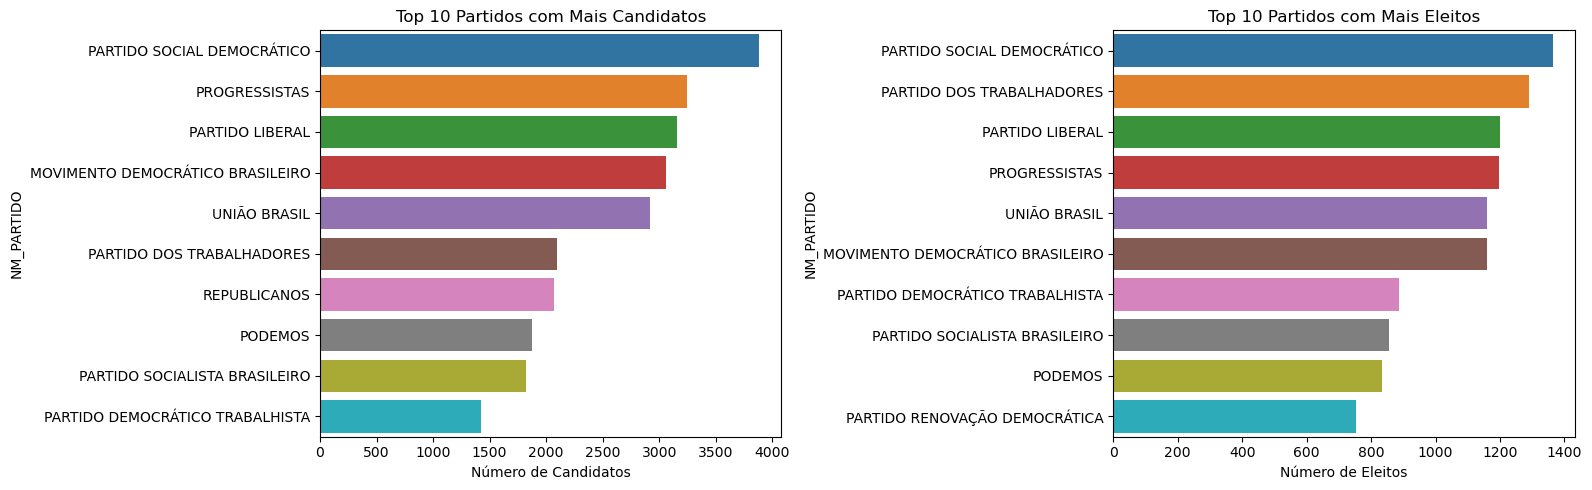

In [22]:
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

sns.countplot(data=df, x='DS_OCUPACAO', ax=axs[0,0])
axs[0,0].tick_params(axis='x', rotation=90)
axs[0,0].set_title('Ocupações')

sns.countplot(data=df, x='DS_GRAU_INSTRUCAO', ax=axs[0,1])
axs[0,1].tick_params(axis='x', rotation=90)
axs[0,1].set_title('Escolaridade')

sns.countplot(data=df, x='DS_COR_RACA', ax=axs[0,2])
axs[0,2].tick_params(axis='x', rotation=45)
axs[0,2].set_title('Cor/Raça')

sns.countplot(data=df, x='DS_GENERO', ax=axs[1,0])
axs[1,0].set_title('Gênero')

sns.countplot(data=df, x='FAIXA_ETARIA', ax=axs[1,1])
axs[1,1].set_title('Faixa Etária')

sns.countplot(data=df, x='DS_ESTADO_CIVIL', ax=axs[1,2])
axs[1,2].tick_params(axis='x', rotation=45)
axs[1,2].set_title('Estado Civil')

plt.tight_layout()
plt.show()

mais_candidatos = df['NM_PARTIDO'].value_counts().head(10)
print("Partidos com mais candidatos:")
print(mais_candidatos)

mais_eleitos = df[df['ELEITO'] == 1]['NM_PARTIDO'].value_counts().head(10)
print("\nPartidos com mais eleitos:")
print(mais_eleitos)

fig, ax = plt.subplots(1, 2, figsize=(16,5))

sns.barplot(x=mais_candidatos.values, y=mais_candidatos.index, ax=ax[0])
ax[0].set_title("Top 10 Partidos com Mais Candidatos")
ax[0].set_xlabel("Número de Candidatos")

sns.barplot(x=mais_eleitos.values, y=mais_eleitos.index, ax=ax[1])
ax[1].set_title("Top 10 Partidos com Mais Eleitos")
ax[1].set_xlabel("Número de Eleitos")

plt.tight_layout()
plt.show()

## 5. Classificação: Previsão de Eleição

In [23]:
features = ['DS_OCUPACAO', 'DS_GRAU_INSTRUCAO', 'DS_COR_RACA', 'DS_GENERO',
            'FAIXA_ETARIA', 'DS_ESTADO_CIVIL', 'SG_PARTIDO']

X = pd.get_dummies(df[features])
y = df['ELEITO']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

print("Acurácia:", clf.score(X_test, y_test))


Acurácia: 0.5947097722263042


## 6. Clusterização

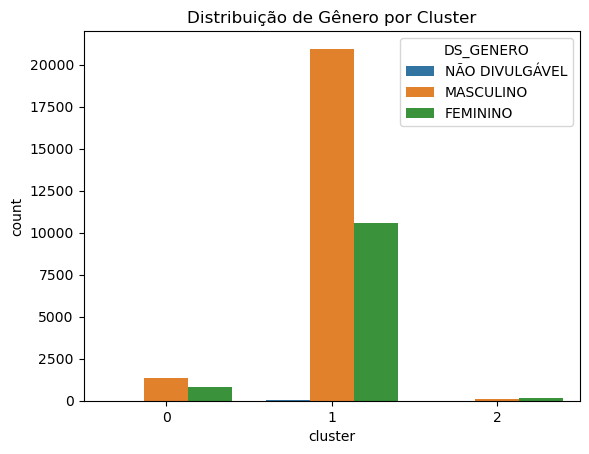

In [24]:
X_cluster = pd.get_dummies(df[features])
X_scaled = StandardScaler().fit_transform(X_cluster)

kmeans = KMeans(n_clusters=3, random_state=42).fit(X_scaled)
df['cluster'] = kmeans.labels_

sns.countplot(data=df, x='cluster', hue='DS_GENERO')
plt.title('Distribuição de Gênero por Cluster')
plt.show()

## 7. Regras de associação

In [25]:
assoc_df = df[['DS_GENERO', 'DS_COR_RACA', 'DS_GRAU_INSTRUCAO', 'DS_ESTADO_CIVIL', 'ELEITO']].copy()
assoc_df = pd.get_dummies(assoc_df.astype(str))

frequents = apriori(assoc_df, min_support=0.1, use_colnames=True)
rules = association_rules(frequents, metric='confidence', min_threshold=0.6)

rules.sort_values(by='confidence', ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
47,"(DS_GRAU_INSTRUCAO_SUPERIOR COMPLETO, ELEITO_1)",(DS_COR_RACA_BRANCA),0.141971,0.696364,0.111813,0.787578,1.130986,1.0,0.012950,1.429397,0.134978,0.153902,0.300405,0.474072
45,"(DS_ESTADO_CIVIL_CASADO(A), DS_GRAU_INSTRUCAO_...",(DS_COR_RACA_BRANCA),0.168131,0.696364,0.131536,0.782343,1.123468,1.0,0.014456,1.395018,0.132111,0.179459,0.283164,0.485616
12,(DS_GRAU_INSTRUCAO_SUPERIOR COMPLETO),(DS_COR_RACA_BRANCA),0.284971,0.696364,0.220334,0.773182,1.110313,1.0,0.021891,1.338677,0.138950,0.289533,0.252994,0.544795
58,"(DS_ESTADO_CIVIL_CASADO(A), DS_COR_RACA_BRANCA...",(DS_GENERO_MASCULINO),0.197172,0.659269,0.151877,0.770274,1.168376,1.0,0.021887,1.483207,0.179504,0.215561,0.325785,0.500323
40,"(DS_ESTADO_CIVIL_CASADO(A), ELEITO_1)",(DS_GENERO_MASCULINO),0.273743,0.659269,0.210782,0.769999,1.167958,1.0,0.030311,1.481431,0.198008,0.291848,0.324977,0.544859
22,"(DS_GENERO_MASCULINO, DS_GRAU_INSTRUCAO_SUPERI...",(DS_COR_RACA_BRANCA),0.166868,0.696364,0.128391,0.769420,1.104911,1.0,0.012191,1.316838,0.113967,0.174720,0.240605,0.476897
46,"(DS_GRAU_INSTRUCAO_SUPERIOR COMPLETO, ELEITO_0)",(DS_COR_RACA_BRANCA),0.143000,0.696364,0.108521,0.758890,1.089789,1.0,0.008941,1.259326,0.096139,0.148488,0.205924,0.457365
52,"(DS_ESTADO_CIVIL_CASADO(A), DS_COR_RACA_BRANCA...",(DS_GENERO_MASCULINO),0.146792,0.659269,0.108110,0.736484,1.117121,1.0,0.011334,1.293016,0.122880,0.154896,0.226614,0.450234
32,"(DS_ESTADO_CIVIL_CASADO(A), DS_GRAU_INSTRUCAO_...",(DS_GENERO_MASCULINO),0.211458,0.659269,0.155345,0.734640,1.114325,1.0,0.015938,1.284032,0.130108,0.217150,0.221203,0.485136
35,"(ELEITO_1, DS_GRAU_INSTRUCAO_ENSINO MÉDIO COMP...",(DS_GENERO_MASCULINO),0.172452,0.659269,0.125658,0.728652,1.105242,1.0,0.011965,1.255695,0.115063,0.177969,0.203629,0.459627
